### Example notebook for a general script to run aging cycle

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import csv, random, os,sys
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
########################     Global settings!!!
rows_per_file = 4;  Scan_end_end = 1000;
purpose_i = "Sweep_Age"

On_HPC = False 
Runshort = False                    # a long run or a quick test

if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 232; # manually specify

Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters

In [3]:
# specify path:
if On_HPC:                          # Run on HPC
    Path_Data_pre = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = f"InputData/{purpose_i}/"  +  para_csv
else:
    Path_Data_pre = os.path.expanduser(
        "~/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave/Example_Expdata") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave/Results")
    Para_file = os.path.expanduser(
        "~/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave")+f'/Get_Input/{purpose_i}/'+para_csv

if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);

from scripts.HPC_Li_et_al.ParaSweeper.Fun_HPC import *
parameter_names, combinations = load_combinations_from_csv(Para_file)

In [4]:
pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1

# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

# try to plot experiment data
Path_Data  = Path_Data_pre+"/example_Age_SOH.csv"
my_data = pd.read_csv( Path_Data)

cap_thr   = my_data["Charge Throughput (A.h)"] / 1e3
cap_C_10  = my_data["C/10 Capacity (mA.h)"]/1e3
soh_C_10  = cap_C_10 / cap_C_10[0] * 100
# plt.plot(cap_thr,soh_C_10,"-o")
cap_thr   = np.array(cap_thr).tolist()
cap_C_10  = np.array(cap_C_10).tolist()
soh_C_10  = np.array(soh_C_10).tolist()
XY_Exp =[cap_thr,soh_C_10]

#####################################################################
########################  Define experiment  ########################
#####################################################################
V_max = 4.2;        V_min = 2.5; 
exp_AGE_text = [(
    f"Discharge at 1C until {V_min}V", 
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max} V until C/100",
    ),  ]  # *  78
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;
exp_RPT_text = [ (
    # refill
    "Rest for 1 minutes", # change this step to rest to avoid errors. 
    "Rest for 1 hours", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours",
    ) ] * 1
exp_breakin_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours",
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
cycle_no = -1

Total scan case is 4


In [5]:
#####################################################################
########################  Output  ###################################
#####################################################################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Y or N",
    "Error %","Punish",
    "Dry out",]

head_pos = [ 
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
if not os.path.exists(BasicPath +Target):
    os.mkdir(BasicPath +Target);
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack =[
    exp_AGE_text,exp_RPT_text,exp_breakin_text,
    step_AGE_CD,step_AGE_CC,step_AGE_CV,
    step_0p1C_CD ,step_0p1C_CC,step_0p1C_RE,
    cycle_no,book_name_xlsx,
    ] 
if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [6]:
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  flag_RunOneCyc = False
Return_Sol=True;   Check_Small_Time=True;
fs = 13; dpi = 100;

midc_merge,Sol_RPT,Sol_AGE,Call_Age= Run_model (
    Para_dict_list[1],BasicPath, XY_Exp, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time) 

Your own print statement
Start Now! Scan 926.
Scan 926: DryOut = On
Scan 926: Spent 18.450 ms on Initialization


Initial electrolyte amount is  5.1261558457200005 mL


Scan 926: Finish break-in cycle within 31.146 s
Scan 926: Finish post-process for break-in cycle within 1.029 s
At t = 328.274 and h = 3.27407e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 266.008 and h = 8.64826e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 263.974 and h = 3.27771e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 262.044 and h = 2.17909e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 260.2 and h = 6.70731e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 258.432 and h = 2.60425e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 256.729 and h = 2.49164e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.084 and h = 5.43607e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 253.486 and h = 9.29519e-15, the corrector convergence failed repeatedly or with |h

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish post-process for No.26 ageing cycles within 469.737 ms
At t = 248.939 and h = 7.29436e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.847 and h = 3.99666e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.846 and h = 9.28281e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 186.795 and h = 8.87627e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 186.796 and h = 2.54307e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.758 and h = 1.43467e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.756 and h = 1.12538e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 184.731 and h = 2.71665e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 184.731 and h = 3.14626e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 183.717 and h = 1.617

Succeed to run the ageing set for 26 cycles the 1th time


At t = 199.373 and h = 5.932e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.374 and h = 1.89644e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.55 and h = 4.24138e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.551 and h = 2.04993e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 137.751 and h = 2.88164e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 137.751 and h = 1.61645e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.957 and h = 3.58402e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.957 and h = 2.90487e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.168 and h = 4.22347e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.168 and h = 4.39427e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.78 RPT cycles within 22.894 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.78 RPT cycles within 551.433 ms
At t = 153.075 and h = 2.63351e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 153.074 and h = 3.88935e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.8533 and h = 1.98728e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.8533 and h = 2.37309e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.8532 and h = 2.6778e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.2036 and h = 9.99948e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.2037 and h = 2.68015e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.2039 and h = 1.67181e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 92.558 and h = 1.84295e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 92.5559 and h = 2.89742e-1

Succeed to run the ageing set for 26 cycles the 1th time


At t = 121.788 and h = 2.09804e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 121.788 and h = 2.55206e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 926: Finish for No.104 ageing cycles within 1 minute, 52 seconds
Scan 926: Finish post-process for No.130 ageing cycles within 170.698 ms


Succeed to run the ageing set for 26 cycles the 1th time


At t = 93.3381 and h = 3.28191e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.3384 and h = 2.5483e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.3384 and h = 2.43212e-11, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 926: Finish for No.130 ageing cycles within 1 minute, 59 seconds
Scan 926: Finish post-process for No.156 ageing cycles within 199.673 ms


Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.156 RPT cycles within 23.023 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.156 RPT cycles within 543.471 ms
At t = 539.805 and h = 3.92957e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.357 and h = 2.749e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 538.909 and h = 3.16031e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 538.463 and h = 2.10654e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 538.018 and h = 2.59619e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 537.575 and h = 1.59012e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 537.13 and h = 6.36459e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 536.688 and h = 1.77135e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 536.248 and h = 9.70093e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 535.81 and h = 3.79306e-12

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish post-process for No.182 ageing cycles within 202.256 ms
At t = 519.873 and h = 4.57306e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 519.45 and h = 2.50159e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 519.028 and h = 1.13266e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 518.608 and h = 2.49931e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 518.188 and h = 3.00253e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 517.765 and h = 2.49583e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 517.351 and h = 1.87618e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.934 and h = 3.36628e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.518 and h = 3.45499e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.103 and h = 2.743

Succeed to run the ageing set for 26 cycles the 1th time


At t = 498.544 and h = 1.13585e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 498.15 and h = 2.62941e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 497.757 and h = 6.67496e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 497.365 and h = 1.30861e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 496.973 and h = 2.36888e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 496.582 and h = 2.59102e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 496.193 and h = 1.72126e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.803 and h = 2.4741e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.415 and h = 1.82313e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.027 and h = 2.99731e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.234 RPT cycles within 22.751 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.234 RPT cycles within 562.858 ms
At t = 534.737 and h = 1.55588e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 475.755 and h = 4.04758e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.756 and h = 5.73124e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.756 and h = 1.99484e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 475.39 and h = 3.97463e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.39 and h = 1.05434e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.39 and h = 5.48884e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 475.025 and h = 2.71553e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.025 and h = 1.0001e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.025 and h = 3.13025e-11

Succeed to run the ageing set for 26 cycles the 1th time


At t = 517.061 and h = 1.65529e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 456.708 and h = 2.58564e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 216.708 and h = 1.77696e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.708 and h = 1.21266e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 456.362 and h = 2.87918e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 216.363 and h = 1.65472e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.3628 and h = 2.80303e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 456.019 and h = 1.45817e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 216.017 and h = 5.65795e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.0184 and h = 1.95084e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


At t = 499.571 and h = 2.294e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 439.234 and h = 1.28815e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.236 and h = 2.08048e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 438.909 and h = 1.67196e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.909 and h = 2.08335e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 438.581 and h = 2.18254e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.582 and h = 3.71129e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 438.255 and h = 2.99421e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.255 and h = 4.05089e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 437.929 and h = 2.34154e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.312 RPT cycles within 24.247 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.312 RPT cycles within 597.773 ms
At t = 479.277 and h = 3.20535e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 239.277 and h = 3.89549e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.276 and h = 9.3945e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 420.339 and h = 2.05825e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 180.339 and h = 1.60878e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 420.03 and h = 2.71657e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 180.03 and h = 8.04949e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 419.721 and h = 3.54342e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 179.721 and h = 1.27965e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 419.413 and h = 2.89315e-1

Succeed to run the ageing set for 26 cycles the 1th time


At t = 464.399 and h = 1.00541e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 224.4 and h = 2.03952e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 104.4 and h = 8.73635e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 404.097 and h = 3.91455e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 164.098 and h = 2.49658e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 403.802 and h = 2.77302e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.802 and h = 2.06306e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 403.508 and h = 2.10745e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.507 and h = 2.5504e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 403.213 and h = 1.29604e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

Succeed to run the ageing set for 26 cycles the 1th time


At t = 449.424 and h = 2.28982e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 209.422 and h = 4.3542e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.424 and h = 2.05303e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 389.135 and h = 4.27795e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.134 and h = 2.83388e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 388.851 and h = 3.94884e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 148.851 and h = 5.62505e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 388.569 and h = 2.10609e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 148.568 and h = 7.30446e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 388.287 and h = 8.09712e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.390 RPT cycles within 25.796 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.390 RPT cycles within 698.612 ms
At t = 431.781 and h = 2.4051e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 191.781 and h = 3.9804e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 372.873 and h = 1.39052e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.873 and h = 2.57007e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 372.601 and h = 7.7191e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.603 and h = 2.0765e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 372.333 and h = 3.31447e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.333 and h = 2.15281e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 372.064 and h = 1.80168e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.063 and h = 4.23406e-11

Succeed to run the ageing set for 26 cycles the 1th time


At t = 418.852 and h = 1.61614e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 178.851 and h = 3.57553e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 358.585 and h = 2.46449e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.585 and h = 1.7004e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.585 and h = 1.71192e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 358.325 and h = 1.61478e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.324 and h = 1.70062e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.325 and h = 4.38917e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 358.064 and h = 9.86542e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.066 and h = 3.35869e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


At t = 405.673 and h = 3.28607e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 165.673 and h = 6.07859e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 345.417 and h = 2.14641e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.417 and h = 2.72583e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.417 and h = 2.61996e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 345.166 and h = 2.31807e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.166 and h = 2.35752e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.167 and h = 1.2428e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 344.916 and h = 3.11572e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 104.916 and h = 2.23196e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.468 RPT cycles within 24.801 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.468 RPT cycles within 596.871 ms
At t = 389.978 and h = 1.19356e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.978 and h = 1.86712e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 331.091 and h = 1.74115e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.0913 and h = 5.43735e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.0912 and h = 2.8972e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 330.85 and h = 2.81231e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.8503 and h = 3.31038e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.8502 and h = 2.67417e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 330.609 and h = 5.82695e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.61 and h = 1.63298e-11

Succeed to run the ageing set for 26 cycles the 1th time


At t = 378.502 and h = 1.80861e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.501 and h = 3.90546e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 318.262 and h = 4.68504e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 318.029 and h = 2.95143e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 317.797 and h = 6.91354e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 317.564 and h = 2.70044e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 317.331 and h = 3.00365e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 317.099 and h = 9.86421e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 316.867 and h = 3.46085e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 316.635 and h = 2.57739e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Succeed to run the ageing set for 26 cycles the 1th time


At t = 366.692 and h = 1.96439e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 126.686 and h = 6.41803e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 306.461 and h = 4.30973e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 306.235 and h = 2.27802e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 306.009 and h = 3.14712e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 305.784 and h = 2.56321e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 305.559 and h = 2.02755e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 305.334 and h = 2.35601e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 305.107 and h = 1.185e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 304.884 and h = 1.81472e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.546 RPT cycles within 23.593 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.546 RPT cycles within 605.766 ms
At t = 352.505 and h = 1.62279e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.504 and h = 6.13215e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.505 and h = 2.49624e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 293.635 and h = 4.03469e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 293.418 and h = 1.15485e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 293.2 and h = 2.61031e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 292.982 and h = 3.54101e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 292.765 and h = 3.15719e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 292.547 and h = 3.06963e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 292.33 and h = 2.19689e-1

Succeed to run the ageing set for 26 cycles the 1th time


At t = 342.167 and h = 2.90044e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 102.167 and h = 2.21346e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 102.167 and h = 1.43038e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 281.949 and h = 2.65201e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 281.737 and h = 2.23508e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 281.526 and h = 2.65676e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 281.315 and h = 2.44192e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 281.103 and h = 1.28807e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 280.892 and h = 2.35039e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 280.681 and h = 1.31058e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Succeed to run the ageing set for 26 cycles the 1th time


At t = 331.444 and h = 1.30183e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.4435 and h = 3.76311e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.4437 and h = 2.04907e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 271.233 and h = 2.67475e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 271.027 and h = 2.40457e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 270.821 and h = 1.7102e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 270.615 and h = 1.74666e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 270.41 and h = 2.0902e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 270.205 and h = 1.63629e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 270 and h = 1.46743e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.624 RPT cycles within 23.025 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.624 RPT cycles within 572.659 ms
At t = 318.469 and h = 2.24172e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 259.614 and h = 6.20715e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 259.415 and h = 1.73591e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 259.215 and h = 1.69151e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 259.016 and h = 3.21037e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 258.817 and h = 1.40073e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 258.618 and h = 2.25643e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 258.419 and h = 2.86566e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 258.22 and h = 7.99275e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 258.022 and h = 2.77223e

Succeed to run the ageing set for 26 cycles the 1th time


At t = 309.051 and h = 8.98287e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.853 and h = 3.46452e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.659 and h = 1.46477e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.464 and h = 2.08686e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.27 and h = 2.33063e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.077 and h = 2.79601e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 247.882 and h = 2.08532e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 247.689 and h = 7.41702e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 247.495 and h = 3.05328e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 247.303 and h = 1.22553e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


At t = 299.217 and h = 9.58359e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 239.024 and h = 2.33384e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 239.024 and h = 2.16391e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.024 and h = 1.46355e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 238.834 and h = 1.69359e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 238.834 and h = 3.22433e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.834 and h = 2.63167e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 238.645 and h = 4.0432e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 238.645 and h = 2.84302e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.645 and h = 4.93317e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.702 RPT cycles within 22.990 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.702 RPT cycles within 567.363 ms
At t = 287.244 and h = 2.53333e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.402 and h = 2.00443e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.402 and h = 2.9853e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.402 and h = 2.68677e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.218 and h = 2.88151e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.218 and h = 2.6498e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.218 and h = 2.89438e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.034 and h = 3.65038e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.034 and h = 4.93057e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.034 and h = 2.19985e-

Succeed to run the ageing set for 26 cycles the 1th time


At t = 278.592 and h = 1.77502e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.407 and h = 1.74497e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.407 and h = 2.00063e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.4074 and h = 6.67347e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.227 and h = 2.36652e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.228 and h = 1.29431e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.2272 and h = 7.74661e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.048 and h = 3.09317e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.048 and h = 2.45869e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.0482 and h = 1.991e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish post-process for No.754 ageing cycles within 222.575 ms
At t = 269.499 and h = 2.6448e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 209.319 and h = 2.52617e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 209.319 and h = 1.49702e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.3185 and h = 2.41875e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 209.143 and h = 2.91304e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 209.143 and h = 2.50269e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.1429 and h = 2.04496e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 208.967 and h = 8.63682e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 208.967 and h = 2.59853e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.967 and h = 4.7502

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.780 RPT cycles within 23.551 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.780 RPT cycles within 705.034 ms
At t = 258.363 and h = 9.61929e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.534 and h = 2.39717e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.534 and h = 2.84919e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.363 and h = 2.06435e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.363 and h = 2.30749e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.192 and h = 2.84294e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.191 and h = 2.93483e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.02 and h = 3.03593e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.019 and h = 2.51112e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.85 and h = 1.42635e-

Succeed to run the ageing set for 26 cycles the 1th time


At t = 250.354 and h = 1.46912e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.182 and h = 1.8392e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.182 and h = 1.80293e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.014 and h = 2.97685e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.014 and h = 4.17073e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 189.847 and h = 1.7548e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 189.847 and h = 3.89218e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 189.679 and h = 3.11136e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 189.68 and h = 4.85455e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 189.513 and h = 1.75367e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Succeed to run the ageing set for 26 cycles the 1th time


At t = 241.885 and h = 3.03054e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.715 and h = 1.71074e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.717 and h = 2.4031e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.553 and h = 3.85115e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.553 and h = 2.955e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.388 and h = 3.99967e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.389 and h = 1.96451e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.225 and h = 2.77007e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.225 and h = 1.12996e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.061 and h = 2.73961e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.858 RPT cycles within 22.556 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.858 RPT cycles within 552.514 ms


Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 231.443 and h = 2.62605e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 231.443 and h = 3.01146e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 111.443 and h = 3.13598e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 172.627 and h = 1.72351e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 172.627 and h = 2.42114e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 172.467 and h = 2.58062e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 172.467 and h = 2.75064e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 172.307 and h = 1.70828e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 172.306 and h = 3.56119e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 172.146 and h = 2.20388e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Succeed to run the ageing set for 26 cycles the 1th time


At t = 223.989 and h = 1.36694e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.989 and h = 4.32987e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.989 and h = 2.15913e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.826 and h = 2.64609e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.826 and h = 2.97033e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.669 and h = 1.57187e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.669 and h = 1.04181e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.512 and h = 1.76518e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.512 and h = 2.64578e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.354 and h = 4.7616e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


At t = 216.046 and h = 2.8763e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 216.046 and h = 2.85582e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.0465 and h = 1.71393e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 155.888 and h = 2.18117e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 155.888 and h = 1.64853e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 155.734 and h = 1.53955e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 155.733 and h = 2.59026e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 155.579 and h = 3.54629e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 155.579 and h = 2.44604e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 155.425 and h = 1.36673e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.936 RPT cycles within 22.283 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.936 RPT cycles within 558.435 ms


Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 206.149 and h = 1.58887e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 206.149 and h = 1.63402e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.1492 and h = 1.81273e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 147.346 and h = 1.34989e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 147.346 and h = 3.23818e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 147.195 and h = 2.26709e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 147.195 and h = 3.86513e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 147.042 and h = 4.26897e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 147.044 and h = 2.62864e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.893 and h = 4.05758e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Succeed to run the ageing set for 26 cycles the 1th time


At t = 199.222 and h = 2.56025e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.222 and h = 1.83522e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.069 and h = 2.46182e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.069 and h = 1.08873e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.921 and h = 1.61962e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.92 and h = 1.13392e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.772 and h = 3.23303e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.772 and h = 2.85028e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.624 and h = 1.85615e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.624 and h = 2.27469e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


At t = 191.741 and h = 3.05554e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 191.741 and h = 7.542e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.591 and h = 2.72861e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.591 and h = 3.06163e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.446 and h = 1.60544e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.445 and h = 4.34926e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.3 and h = 9.21375e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.3 and h = 2.53221e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.154 and h = 6.45189e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.155 and h = 1.64464e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.1014 RPT cycles within 22.545 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.1014 RPT cycles within 549.659 ms


Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 182.323 and h = 2.4598e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 182.319 and h = 1.3359e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.533 and h = 4.13048e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.533 and h = 6.62277e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.39 and h = 7.45513e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.389 and h = 5.19413e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.247 and h = 5.35503e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.247 and h = 1.58223e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.104 and h = 2.3188e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.104 and h = 2.20664e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t

Succeed to run the ageing set for 26 cycles the 1th time


At t = 175.864 and h = 2.76997e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 175.864 and h = 3.37824e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.719 and h = 4.8651e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.719 and h = 2.01007e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.719 and h = 3.07213e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.578 and h = 1.65761e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.578 and h = 2.37253e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.578 and h = 3.44592e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.438 and h = 1.55357e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.438 and h = 2.84913e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Succeed to run the ageing set for 26 cycles the 1th time


At t = 168.793 and h = 3.0373e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 168.793 and h = 4.25168e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.651 and h = 2.75001e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.651 and h = 3.81355e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.651 and h = 2.42158e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.513 and h = 2.66964e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.513 and h = 3.37365e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.513 and h = 2.43068e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.375 and h = 4.02114e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.375 and h = 2.3212e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.1092 RPT cycles within 22.987 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.1092 RPT cycles within 561.477 ms


Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 159.8 and h = 2.74298e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 159.8 and h = 2.21286e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.023 and h = 8.23452e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.023 and h = 2.10709e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.023 and h = 2.38098e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.888 and h = 1.81532e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.888 and h = 3.0513e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.888 and h = 2.2143e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.752 and h = 2.98575e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.753 and h = 1.83216e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Succeed to run the ageing set for 26 cycles the 1th time


At t = 153.761 and h = 1.23164e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 153.761 and h = 2.0721e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.6223 and h = 3.02194e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.6231 and h = 2.39695e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.6231 and h = 3.30789e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.4902 and h = 1.92842e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.49 and h = 2.2795e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.4899 and h = 2.6065e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.3563 and h = 5.01412e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.3567 and h = 2.46298e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

Succeed to run the ageing set for 26 cycles the 1th time


At t = 147.057 and h = 3.97549e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 147.057 and h = 2.43487e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.9226 and h = 1.47795e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.9226 and h = 2.68794e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.9226 and h = 2.05878e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.7915 and h = 7.04463e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.791 and h = 3.02936e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.7914 and h = 7.3233e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.6603 and h = 2.10903e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.6603 and h = 2.20815e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

Succeed to run the ageing set for 26 cycles the 1th time


Scan 926: Finish for No.1170 RPT cycles within 23.000 s


Succeed to run RPT for the 1th time


Scan 926: Finish post-process for No.1170 RPT cycles within 684.096 ms
Scan 926: Getting extra variables within 159.700 us
Scan 926: Finish all plots within 4.178 s
Scan 926: Successfully save mat file!
Scan 926: Try saving within 21.886 ms
Succeed doing something in 2 hours, 28 minutes, 15 seconds
This is the end of No. 926 scan


Successfully create a excel file


In [15]:
[my_dict_RPT, my_dict_AGE,mdic_dry] = midc_merge

In [9]:
# Write summary into excel
Index_List_succeed = index_list
for k,index_i in enumerate(Index_List_succeed):
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = table_tar.max_row # ncolumns_old + k +1 # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 



Something goes wrong for Scan 925!
Successfuly write results for Scan 926!
Something goes wrong for Scan 927!
Something goes wrong for Scan 928!


Text(0, 0.5, 'LLI %')

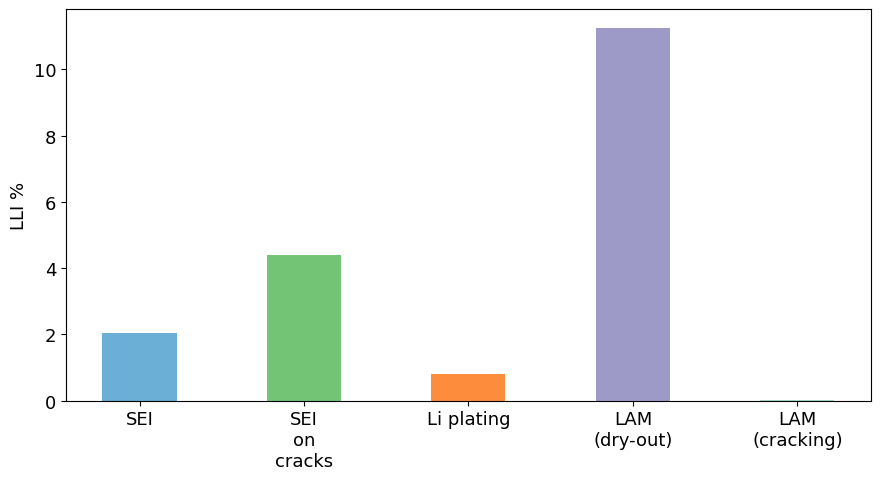

In [12]:
# DMA component:
fig, ax = plt.subplots(figsize=(9,5),tight_layout=True) 
def adjust_category_names(categories):
    return ['\n'.join(category.split()) if len(category) > 12 else category for category in categories]

categories = ['SEI', 'SEI on cracks', 'Li plating', 'LAM (dry-out)','LAM (cracking)']
adjusted_categories = adjust_category_names(categories)
colors = ['#6baed6', '#74c476', '#fd8d3c', '#9e9ac8',"#a2d9ce"]
values = [
    my_dict_RPT["CDend LLI SEI [%]"][-1], 
    my_dict_RPT["CDend LLI SEI on cracks [%]"][-1], 
    my_dict_RPT["CDend LLI lithium plating [%]"][-1] , 
    my_dict_RPT["LAM_to_Dry [%] end"] ,
    my_dict_RPT["LAM_to_Crack_NE [%] end"]   ]

plt.bar(adjusted_categories, values, color= colors,width=0.45 )
plt.ylabel('LLI %')


In [13]:
print(my_dict_RPT["LAM_to_Crack_NE [%] end"],my_dict_RPT["LAM_to_Crack_PE [%] end"])

0.00753898990005375 2.842170943040401e-14


fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True) 
width = 0.45
categories = ['Dry out', 'Stress',]
values_ne = [LAM_to_Dry_i,LAM_to_Crack_NE_i]
values_pe = [LAM_to_Dry_i,LAM_to_Crack_PE_i]
axs[0].bar(categories, values_ne, width )
axs[1].bar(categories, values_pe, width )
axs[0].set_ylabel("LAM NE %")
axs[1].set_ylabel("LAM PE %")

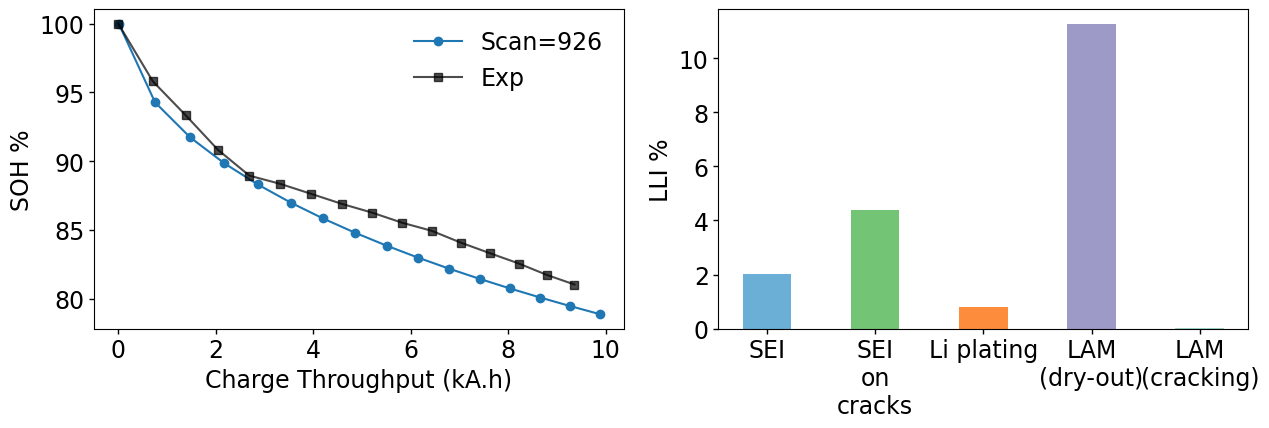

In [28]:
##### newly defined:
fs=17; 
font = {'family' : 'DejaVu Sans','size': fs}
mpl.rc('font', **font)

Scan_i = 926; Temper_i = 273.15 + 40


fig, axs = plt.subplots(1,2, figsize=(13,4.6),tight_layout=True)
axs[0].plot(
    my_dict_RPT['Throughput capacity [kA.h]'], 
    my_dict_RPT['CDend SOH [%]'],     
    '-o', label="Scan=" + str(Scan_i) )

categories = ['SEI', 'SEI on cracks', 'Li plating', 'LAM (dry-out)','LAM (cracking)']
adjusted_categories = adjust_category_names(categories)
colors = ['#6baed6', '#74c476', '#fd8d3c', '#9e9ac8',"#a2d9ce"]
values = [
    my_dict_RPT["CDend LLI SEI [%]"][-1], 
    my_dict_RPT["CDend LLI SEI on cracks [%]"][-1], 
    my_dict_RPT["CDend LLI lithium plating [%]"][-1] , 
    my_dict_RPT["LAM_to_Dry [%] end"] ,
    my_dict_RPT["LAM_to_Crack_NE [%] end"]   ]

# Creating the bar plot
axs[1].bar(adjusted_categories, values, color= colors,width=0.45 )

# Plot Charge Throughput (A.h) vs SOH
color_exp     = [0, 0, 0, 0.3]; marker_exp     = "v";
color_exp_Avg = [0, 0, 0, 0.7]; marker_exp_Avg = "s";
if Plot_Exp == True:
    [X_exp,Y_exp] = XY_Exp
    axs[0].plot(
        X_exp,Y_exp,color=color_exp_Avg,
        marker=marker_exp_Avg,label=f"Exp") 
axs[0].set_ylabel("SOH %")
axs[1].set_ylabel("LLI %")
axs[0].set_xlabel("Charge Throughput (kA.h)")
for i in range(0,2):
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); 
    [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1);del labels
axs[0].legend(prop={'family':'DejaVu Sans','size':fs},loc='best',frameon=False)

plt.savefig(
    BasicPath + Target+    "Plots/" +  
    f"0_Scan_{Scan_i}-{str(int(Temper_i- 273.15))}degC SOH and LLI break down.png", dpi=dpi) 
plt.savefig(
    BasicPath + Target+    "Plots/" +  
    f"0_Scan_{Scan_i}-{str(int(Temper_i- 273.15))}degC SOH and LLI break down.svg")  

In [29]:
print(my_dict_RPT["CDend LLI lithium plating [%]"][-1])

0.8131300317118388


/home/ruihe_li/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave/Results/Sweep_Age


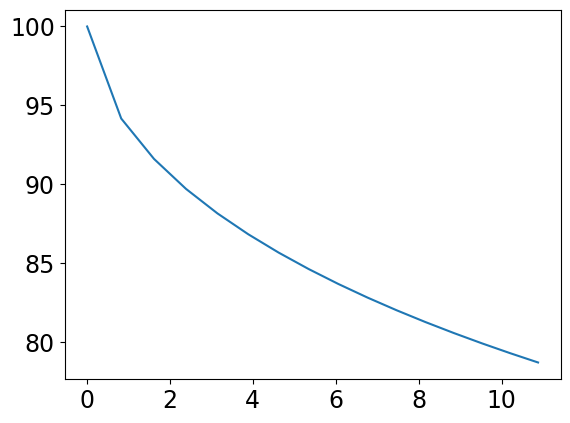

In [26]:
Root_Path = os.path.expanduser(
   "~/EnvPB_Linux/PyBaMM/scripts/HPC_Li_et_al/HPC_Paper_SimSave/Results")
purpose_i = "Sweep_Age"
BasicPath_2 = os.path.join(Root_Path, purpose_i)
print(BasicPath_2)
import scipy.io
my_dict_mat = scipy.io.loadmat(BasicPath_2
    +'/Sweep_Age_Case_925_928/Mats/926-Ageing_summary_only.mat')
plt.plot(
    my_dict_mat['Throughput capacity [kA.h]'][0],
    my_dict_mat['CDend SOH [%]'][0])

In [25]:
my_dict_mat['Throughput capacity [kA.h]']

array([[ 0.01120727,  0.83219187,  1.62217976,  2.39294972,  3.14878442,
         3.89216854,  4.62478087,  5.34784853,  6.06231416,  6.76892845,
         7.46831094,  8.16099381,  8.84743979,  9.52804873, 10.20316436,
        10.87308527]])